In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-10-21 09:49:54.124172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# from importlib import reload
# reload(ck)

In [5]:
ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
L_vars = len(ind_pick_from_batch)

In [6]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*lead4.npy"))

filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*lead4.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

In [7]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v4/*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v4/*pos*lead2.npy"))

In [8]:
len(filename_pos_valid)

453

In [9]:
filename_valid = filename_neg_valid[::80] + filename_pos_valid

In [10]:
len(filename_valid)

5511

In [11]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

In [12]:
L_valid = len(filename_valid)
L_var = L_vars

TEST_input_64 = np.empty((L_valid, 64, 64, L_var))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

**ConvNext**

In [13]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [15]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6


model_name='Branch64X'
input_shape=(64, 64, 15)
IN64 = layers.Input(shape=input_shape)
X = IN64

X = layers.LocallyConnected2D(64, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc1_norm".format(model_name))(X)
X = layers.Activation("gelu", name="{}_lc1_gelu".format(model_name))(X)

# X = layers.LocallyConnected2D(96, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
# X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc2_norm".format(model_name))(X)
# X = layers.Activation("gelu", name="{}_lc2_gelu".format(model_name))(X)

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=3, padding='same', name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=3, padding='same', name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

V1 = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

OUT = layers.Dense(256, name="{}_dense1".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN64, outputs=OUT, name=model_name)

In [16]:
# OUT1 = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
# OUT1 = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT1)

# OUT2 = layers.GlobalMaxPooling2D(name="{}_head_pool32".format(model_name))(V2)
# OUT2 = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm32".format(model_name))(OUT2)

# OUT = layers.Concatenate(axis=-1, name='concat_64_32')([OUT1, OUT2])

# OUT = layers.Dense(256, name="{}_dense1".format(model_name))(OUT)
# OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
# OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

# OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

# model = Model(inputs=[IN64, IN32], outputs=OUT, name=model_name)

In [17]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss


def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [18]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [19]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'SK15_ISO_Lead2'

model_name = '{}_pp12'.format(key)
model_path = temp_dir+model_name

# W_old = k_utils.dummy_loader(temp_dir+'LCD_12_Lead2_pp12_tune')
# model.set_weights(W_old)

In [20]:
# batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
# temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# key = 'SHM_12_Lead2'

# model_name = '{}_pp12_tune'.format(key)
# model_path = temp_dir+model_name

# W_old = k_utils.dummy_loader(temp_dir+'SHM_12_Lead2_pp12')
# model.set_weights(W_old)


In [ ]:
#model.summary()

In [22]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-5))
#keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
#X_batch_32 = np.empty((batch_size, 32, 32, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
#X_batch_32[...] = np.nan
Y_batch[...] = np.nan

In [24]:
Y_pred = model.predict([TEST_input_64])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2022-10-21 09:56:52.307594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-21 09:56:52.308052: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-10-21 09:56:52.908631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-21 09:56:53.597390: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [25]:
# save_dict = {}
# save_dict['y_true'] = TEST_target
# save_dict['y_pred'] = Y_pred

# np.save("ALL_pred_lead2.npy", save_dict)

In [26]:
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred)
print("Initial record: {}".format(record))

0.4449622133784621
Initial record: 0.4449622133784621


In [27]:
# 0.034775568168985756
# Initial record: 0.034775568168985756

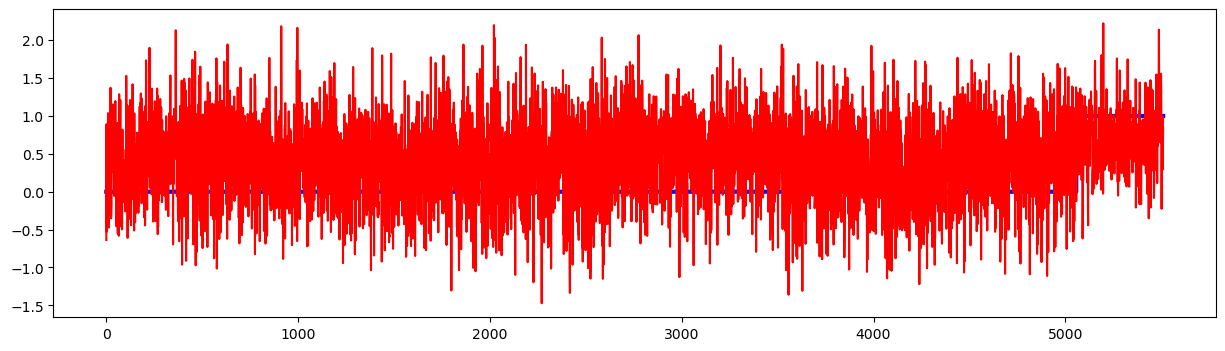

In [28]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target[:], 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r-')
#plt.plot(Y_pred>0.5)

In [29]:
# plt.pcolormesh(TEST_input[3154, ..., 2], cmap=plt.cm.nipy_spectral_r)
# plt.colorbar()

In [30]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
# ========== Training loop ========== #
L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        #N_aug = int(np.random.uniform(2, 7))
        N_aug = int(np.random.uniform(8, 14))
        #N_aug = int(np.random.uniform(10, 25))
        #N_aug = int(np.random.uniform(20, 45))
        
        N_storm = 100 - N_aug
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):

            data = np.load(file_pick[k])
            
            for l, c in enumerate(ind_pick_from_batch):
            
                X_batch_64[k, ..., l] = data[..., c]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        # train on batch
        model.train_on_batch(X_batch_64, Y_batch);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input_64])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.07888251226985545
Validation loss improved from 0.4449622133784621 to 0.07888251226985545
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12


2022-10-21 10:05:29.173985: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 429.9699354171753 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05224232323111397
Validation loss improved from 0.07888251226985545 to 0.05224232323111397
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 447.9366478919983 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04436707768120771
Validation loss improved from 0.05224232323111397 to 0.04436707768120771
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 439.712562084198 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04099282043961879
Validation loss improved from 0.04436707768120771 to 0.04099282043961879
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 444.34052991867065 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03921676400193557
Validation loss improved from 0.04099282043961879 to 0.03921676400193557
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 436.64652490615845 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03893629091280045
Validation loss improved from 0.03921676400193557 to 0.03893629091280045
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 439.06703901290894 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.036832019312779844
Validation loss improved from 0.03893629091280045 to 0.036832019312779844
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 439.82723355293274 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.036394319944148205
Validation loss improved from 0.036832019312779844 to 0.036394319944148205
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 429.39456272125244 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03782192425678591
Validation loss 0.03782192425678591 NOT improved
0.03813869864944839
Validation loss 0.03813869864944839 NOT improved
0.035241380114028095
Validation loss improved from 0.036394319944148205 to 0.035241380114028095
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 499.49628949165344 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03465331030435085
Validation loss improved from 0.035241380114028095 to 0.03465331030435085
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 436.13718724250793 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03350681533499833
Validation loss improved from 0.03465331030435085 to 0.03350681533499833
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 429.97095942497253 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03514873718508956
Validation loss 0.03514873718508956 NOT improved
0.035086227399697294
Validation loss 0.035086227399697294 NOT improved
0.034113147018273636
Validation loss 0.034113147018273636 NOT improved
0.03422243055075354
Validation loss 0.03422243055075354 NOT improved
0.036583012061019965
Validation loss 0.036583012061019965 NOT improved
0.034045310799371724
Validation loss 0.034045310799371724 NOT improved
0.035264769621590496
Validation loss 0.035264769621590496 NOT improved
0.03370763904508131
Validation loss 0.03370763904508131 NOT improved
0.03325122581343281
Validation loss improved from 0.03350681533499833 to 0.03325122581343281
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 424.45221734046936 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03517072586607994
Validation loss 0.03517072586607994 NOT improved
0.03312120056615837
Validation loss improved from 0.03325122581343281 to 0.03312120056615837
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 428.01943826675415 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03520605564783766
Validation loss 0.03520605564783766 NOT improved
0.03436237299404926
Validation loss 0.03436237299404926 NOT improved
0.03402002468602438
Validation loss 0.03402002468602438 NOT improved
0.03292686106547434
Validation loss improved from 0.03312120056615837 to 0.03292686106547434
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 415.52241802215576 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03351072323048847
Validation loss 0.03351072323048847 NOT improved
0.0337324153428612
Validation loss 0.0337324153428612 NOT improved
0.03329235897068085
Validation loss 0.03329235897068085 NOT improved
0.03431543667724873
Validation loss 0.03431543667724873 NOT improved
0.03307645325508159
Validation loss 0.03307645325508159 NOT improved
0.0328958916726525
Validation loss improved from 0.03292686106547434 to 0.0328958916726525
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 414.76007771492004 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.033464997783698845
Validation loss 0.033464997783698845 NOT improved
0.032854939986199067
Validation loss improved from 0.0328958916726525 to 0.032854939986199067
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 414.6021292209625 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.032992618650842666
Validation loss 0.032992618650842666 NOT improved
0.03381663436068364
Validation loss 0.03381663436068364 NOT improved
0.03354307876496943
Validation loss 0.03354307876496943 NOT improved
0.03402610983151746
Validation loss 0.03402610983151746 NOT improved
0.03263073748960576
Validation loss improved from 0.032854939986199067 to 0.03263073748960576
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 422.6050899028778 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.033124248862464935
Validation loss 0.033124248862464935 NOT improved
0.033774971198113436
Validation loss 0.033774971198113436 NOT improved
0.033793503126284825
Validation loss 0.033793503126284825 NOT improved
0.0359846853658281
Validation loss 0.0359846853658281 NOT improved
0.03493519469160064
Validation loss 0.03493519469160064 NOT improved
0.03208884195161185
Validation loss improved from 0.03263073748960576 to 0.03208884195161185
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 423.6797959804535 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03363850165267617
Validation loss 0.03363850165267617 NOT improved
0.03238340863496783
Validation loss 0.03238340863496783 NOT improved
0.0329215214762977
Validation loss 0.0329215214762977 NOT improved
0.03336498680188021
Validation loss 0.03336498680188021 NOT improved
0.0332960312643122
Validation loss 0.0332960312643122 NOT improved
0.0330361485600573
Validation loss 0.0330361485600573 NOT improved
0.03358629439274412
Validation loss 0.03358629439274412 NOT improved
0.03488342263539863
Validation loss 0.03488342263539863 NOT improved
0.035363527630181586
Validation loss 0.035363527630181586 NOT improved
0.03225562274655728
Validation loss 0.03225562274655728 NOT improved
0.032080401124781784
Validation loss improved from 0.03208884195161185 to 0.032080401124781784
save to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_ISO_Lead2_pp12/assets
--- 418.54548358917236 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03248799651748106
Validation loss 0.03248799651748106 NOT improved
0.03452916873124207
Validation loss 0.03452916873124207 NOT improved
0.032408837662355465
Validation loss 0.032408837662355465 NOT improved
0.03220531618549159
Validation loss 0.03220531618549159 NOT improved



KeyboardInterrupt



In [30]:
# ========== Training loop ========== #
L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        #N_aug = int(np.random.uniform(2, 7))
        N_aug = int(np.random.uniform(8, 14))
        #N_aug = int(np.random.uniform(10, 25))
        #N_aug = int(np.random.uniform(20, 45))
        
        N_storm = 100 - N_aug
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):

            data = np.load(file_pick[k])
            
            for l, c in enumerate(ind_pick_from_batch):
            
                X_batch_64[k, ..., l] = data[..., c]
                X_batch_32[k, ..., l] = data[:, 16:-16, 16:-16, c]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        X_batch_32 = X_batch_32[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        # train on batch
        model.train_on_batch([X_batch_64, X_batch_32], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input_64, TEST_input_32])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.07514533614068455
Validation loss improved from 0.2998326700708481 to 0.07514533614068455
save to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12


2022-10-14 13:24:01.764774: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12/assets
--- 633.1284303665161 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04136495989064323
Validation loss improved from 0.07514533614068455 to 0.04136495989064323
save to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12/assets
--- 742.1642851829529 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.038807801316810574
Validation loss improved from 0.04136495989064323 to 0.038807801316810574
save to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12/assets
--- 712.9455497264862 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03177556492371975
Validation loss improved from 0.038807801316810574 to 0.03177556492371975
save to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12/assets
--- 660.8410992622375 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.030470391321217895
Validation loss improved from 0.03177556492371975 to 0.030470391321217895
save to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12/assets
--- 736.8477790355682 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.02832385153894868
Validation loss improved from 0.030470391321217895 to 0.02832385153894868
save to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LCD_12_Lead2_pp12/assets
--- 662.7899610996246 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(

KeyboardInterrupt



In [38]:
j

123844

In [ ]:
https://mesonet.agron.iastate.edu/pickup/wwa/

In [29]:
10 % 3

1